## 4. Define Custom CNN Model
This section defines a convolutional neural network from scratch using Keras. The architecture includes:
- Convolution and MaxPooling layers to extract features
- Dropout layers to reduce overfitting
- Dense layers for final classification

In [7]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## 5.Train the Model with Early Stopping
We train the custom CNN model using:
- **Adam** optimizer
- **Categorical crossentropy** as the loss function
- **EarlyStopping** callback to stop training when validation loss stops improving

This ensures efficient training and prevents overfitting.

In [8]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait after last improvement.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
            verbose (bool): If True, prints a message when early stopping is triggered.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print(f"Early stopping triggered. No improvement in {self.patience} epochs.")
                self.early_stop = True
        return self.early_stop

## Using AMP with Custom Model



To improve training speed, we can utilize Automatic Mixed Precision (AMP) provided by torch.cuda.amp. AMP enables faster training by using lower precision (float16) for parts of the computation while maintaining accuracy with some operations in higher precision (float32).

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import numpy as np
import copy

class_names = ['oral_normal', 'oral_scc']

model = CustomCNN(num_classes=2).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler(device='cuda')
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)

num_epochs = 50
train_losses, val_losses = [], []

best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')

try:
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

       
        model.eval()
        val_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images, labels = images.to('cuda'), labels.to('cuda')

                with autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

     
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

      
        if early_stopping.check_early_stop(avg_val_loss):
            print("Early stopping triggered.")
            break

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")


model.load_state_dict(best_model_wts)
print("Best model weights loaded.")



Epoch 1/50


Train Loss: 0.6745, Val Loss: 0.5975, Val Acc: 0.6905

Epoch 2/50


Train Loss: 0.6155, Val Loss: 0.6080, Val Acc: 0.6575

Epoch 3/50


Train Loss: 0.5732, Val Loss: 0.6003, Val Acc: 0.6760

Epoch 4/50


Train Loss: 0.5482, Val Loss: 0.4897, Val Acc: 0.7725

Epoch 5/50


Train Loss: 0.5224, Val Loss: 0.5094, Val Acc: 0.7440

Epoch 6/50


Train Loss: 0.4947, Val Loss: 0.4648, Val Acc: 0.7915

Epoch 7/50


Train Loss: 0.4773, Val Loss: 0.4820, Val Acc: 0.7595

Epoch 8/50


Train Loss: 0.4410, Val Loss: 0.3992, Val Acc: 0.8025

Epoch 9/50


Train Loss: 0.3987, Val Loss: 0.3480, Val Acc: 0.8510

Epoch 10/50


Train Loss: 0.3755, Val Loss: 0.3637, Val Acc: 0.8285

Epoch 11/50


Train Loss: 0.3577, Val Loss: 0.3336, Val Acc: 0.8510

Epoch 12/50


Train Loss: 0.3384, Val Loss: 0.3022, Val Acc: 0.8675

Epoch 13/50


Train Loss: 0.3053, Val Loss: 0.2898, Val Acc: 0.8710

Epoch 14/50


Train Loss: 0.2871, Val Loss: 0.3130, Val Acc: 0.8725

Epoch 15/50


Train Loss: 0.2764, Val Loss: 0.2678, Val Acc: 0.8800

Epoch 16/50


Train Loss: 0.2450, Val Loss: 0.2800, Val Acc: 0.8835

Epoch 17/50


Train Loss: 0.2313, Val Loss: 0.2466, Val Acc: 0.8950

Epoch 18/50


Train Loss: 0.1957, Val Loss: 0.2287, Val Acc: 0.9045

Epoch 19/50


Train Loss: 0.1871, Val Loss: 0.2712, Val Acc: 0.9045

Epoch 20/50


Train Loss: 0.1774, Val Loss: 0.2550, Val Acc: 0.8965

Epoch 21/50


Train Loss: 0.1507, Val Loss: 0.2164, Val Acc: 0.9190

Epoch 22/50


Train Loss: 0.1465, Val Loss: 0.2027, Val Acc: 0.9160

Epoch 23/50


Train Loss: 0.1098, Val Loss: 0.2829, Val Acc: 0.9070

Epoch 24/50


Train Loss: 0.1346, Val Loss: 0.2256, Val Acc: 0.9185

Epoch 25/50


Train Loss: 0.1061, Val Loss: 0.3240, Val Acc: 0.8765

Epoch 26/50


Train Loss: 0.0939, Val Loss: 0.2718, Val Acc: 0.9155

Epoch 27/50


Train Loss: 0.0896, Val Loss: 0.2501, Val Acc: 0.9115
Early stopping triggered. No improvement in 5 epochs.
Early stopping triggered.
Best model weights loaded.


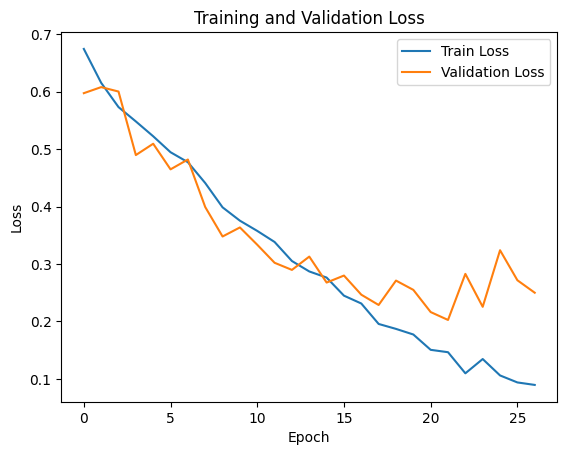

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Model Evaluation and Metrics Calculation

In [11]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()

all_preds = []
all_labels = []

# Run inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')

        outputs = model(images)


        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())   


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')


print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 90.41%
Precision: 0.9052
Recall: 0.9041
F1 Score: 0.9041
